<a href="https://colab.research.google.com/github/meashu31/AIML-Capstone-CV9/blob/Vadhi_master/Unet_Models_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Gogle Drive

In [ ]:
pip install segmentation-models

In [ ]:
pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.23-cp36-none-any.whl size=6405 sha256=33cbe25734de5cf43d820c52c209a8e3211f1188b966c97785b40275ab4ee6e1
  Stored in directory: /root/.cache/pip/wheels/c0/78/33/da5ed769fab5587fcdae95271e8d19106e3b92b3ae2d46382d
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.9-cp36-none-any.whl size=6476 sha256=c0524ad8a4d6f102983f01ca6fdcff52a068e82dffe43508e398ee8d326b5dba
  Stored in directory: /root/.cache/pip/wheels/9d/e9/ec/ca775287a4d0f9e87a56220bf82ca01d9cff045026271fad24
Successfully built plot-keras-history sanitize-ml-labels


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
#------------------------- Load necessary libraries -------------------------#
####------------------------- for loading path -------------------------#
import os
import pickle
from tqdm import tqdm
from matplotlib import image
from matplotlib import pyplot
from plot_keras_history import plot_history
####------------------------- for DataGenerator -------------------------#
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
####------------------------- for Plotting -------------------------#
import matplotlib.pyplot as plt
####------------------------- for Model -------------------------#
from keras.utils.layer_utils import count_params
from tabulate import tabulate
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import *
from keras.layers import  *
import tensorflow as tf

import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt

IMAGE_HEIGHT=224
IMAGE_WIDTH=224
batch_size = 16

In [ ]:
#------------------------- Declare required path -------------------------#
ProjectPath = '/content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/'
CSVPath = os.path.join(ProjectPath,"DataSet_CSV")
Normal = os.path.join(ProjectPath,'Balanced_Data/Normal')
NormalImg = os.path.join(ProjectPath,'Balanced_Data/Normal/image_data/images')
NormalMask = os.path.join(ProjectPath,'Balanced_Data/Normal/mask_data/masks')
Pneumonia = os.path.join(ProjectPath,'Balanced_Data/Pneumonia')
PneumoniaImg = os.path.join(ProjectPath,'Balanced_Data/Pneumonia/image_data/images')
PneumoniaMask = os.path.join(ProjectPath,'Balanced_Data/Pneumonia/mask_data/masks')
RawImg = os.path.join(ProjectPath,'data/image_data/images')
RawMask = os.path.join(ProjectPath,'data/mask_data/masks')

os.chdir(ProjectPath) #changing the current directory path to the project direcotry where the dataset is available
#------------------------- Load CSV to get label info -------------------------#

In [ ]:
#------------------------- Run This code onlt if ID_List.pkl not available -------------------------#
#NormalList = os.listdir(NormalImg)
#PneumoniaList = os.listdir(PneumoniaImg)

#ID_Target = pd.read_csv(os.path.join(CSVPath,"stage_2_train_labels.csv")).reset_index()
#ID_Target = ID_Target.drop(['index','x','y','width','height'],axis=1)

#for i in tqdm(ID_Target.index): 
#  ID = ID_Target.patientId[i]+'.png'
#  Target = ID_Target.Target[i]
#  if Target == 0:
#    if not ID in NormalList:
#      NormalList.append(ID)
#      shutil.copy(RawImg+'/'+ID, NormalImg) #Copy Normal Image
#      shutil.copy(RawMask+'/'+ID, NormalMask) #Copy Normal Mask
#  else:
#    if not ID in PneumoniaList:
#      PneumoniaList.append(ID)
#      shutil.copy(RawImg+'/'+ID, PneumoniaImg) #Copy Pneumonia Image
#      shutil.copy(RawMask+'/'+ID, PneumoniaMask) #Copy Pneumonia Mask

#print('NormalList',len(NormalList))
#print('PneumoniaList',len(PneumoniaList))

#with open(ProjectPath+'/ID_List.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#    pickle.dump([NormalList, PneumoniaList], f)

In [ ]:
# Getting back the objects:
with open(ProjectPath+'/ID_List.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    NormalList, PneumoniaList = pickle.load(f)

print('NormalList',len(NormalList))
print('PneumoniaList',len(PneumoniaList))

NormalList 20672
PneumoniaList 6012


## Backboned-UNet

In [ ]:
def create_model(Backbone='vgg16',pretrained=True,ShowSummery=False,TrainModel=True,TestModel=True):
  # Data Generator
  preprocess_input = get_preprocessing(Backbone)
  seed = 1
  # this is the augmentation configuration we will use for training
  train_img_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split=0.2)
  train_mask_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split=0.2)
  # this is the augmentation configuration we will use for testing: only rescaling
  test_img_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)
  test_mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

  # this is a generator that will read pictures found in subfolers of 'data/train', and indefinitely generate batches of augmented image data
  #------------------------- Train DataSetGenerator -------------------------#
  train_img_generator = train_img_datagen.flow_from_directory('Balanced_Data/Pneumonia/image_data',target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),batch_size=batch_size,class_mode=None,subset='training',seed=seed)
  train_mask_generator = train_mask_datagen.flow_from_directory('Balanced_Data/Pneumonia/mask_data',target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),batch_size=batch_size,class_mode=None, color_mode="grayscale",subset='training',seed=seed)
  #------------------------- Validation DataSetGenerator -------------------------#
  validation_img_generator =  test_img_datagen.flow_from_directory('Balanced_Data/Pneumonia/image_data',target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),batch_size=batch_size,class_mode=None,subset='validation',seed=seed)
  validation_mask_generator =  test_mask_datagen.flow_from_directory('Balanced_Data/Pneumonia/mask_data',target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),batch_size=batch_size,class_mode=None, color_mode="grayscale",subset='validation',seed=seed)
  #----- Zip Data----
  train_generator = (pair for pair in zip(train_img_generator, train_mask_generator))
  validation_generator = (pair for pair in zip(validation_img_generator, validation_mask_generator))
  
  # define model
  print("-------------------Generating UNet Model----------------------")
  model = Unet(Backbone, encoder_weights='imagenet', input_shape=(224, 224, 3))
  ##-------------------getLast layer and add reshape----------------------
  OneThrird = int(len(model.layers)/3)
  for layer in model.layers[:OneThrird]:
      layer.trainable=False
  for layer in model.layers[OneThrird:]:
      layer.trainable=True

  # Model Overview
  trainable_count = count_params(model.trainable_weights)
  non_trainable_count = count_params(model.non_trainable_weights)
  print()
  print(tabulate([['Model', 'UNet'],\
                          ['BackBone', Backbone],\
                          ['Number of Layers', len(model.layers)],\
                          ['Total params', model.count_params()],\
                          ['Trainable params', trainable_count],\
                          ['Non-trainable params', non_trainable_count]],\
                          headers=['Header', 'Value'], tablefmt='orgtbl'))
  print()
  #If Choosen Show Summery
  
  if ShowSummery: 
    print("-------------------Model Summery----------------------")
    model.summary()
  if TrainModel:
    print("-------------------Training Model----------------------")
    # Compile model
    Adam=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=False)
    model.compile(loss="binary_crossentropy", optimizer='Adam', metrics=[['accuracy',tf.keras.metrics.MeanIoU(num_classes=2)]])
    # checkpoint
    filepath = '/content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/UNet_Model_Weights/' + Backbone + "/"
    checkpoint = ModelCheckpoint(filepath+"model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True, save_weights_only=True, mode="min", period=1)
    stop = EarlyStopping(monitor="loss", patience=2, mode="min")
    history = model.fit(train_generator,
                    epochs=5,
                    use_multiprocessing = True, workers = 4,
                    steps_per_epoch = 50,#21348//(batch_size**2),
                    validation_data=validation_generator,
                    validation_steps = 25,#5336//(batch_size**2),
                    callbacks= [checkpoint, stop]).history
    #--------------------- Plot Loss and Accuracy --------------
    plot_history(history)
    plt.show()
    plot_history(history, path=filepath + "standard.png")
    plt.close()
  #---------------- DO NOT USE TEST AS OF NOW --------------------
  if TestModel:
    test_list = ['0a2c130c-c536-4651-836d-95d07e9a89cf.png','0a03fbf6-3c9a-4e2e-89ce-c7629ae43a27.png']
    test_gen = DataGenerator(list_IDs=test_list , image_path = im_path, mask_path=mask_path,dim=(224,224),batch_size=8,resize=True, preprocessinput=PreprocessInput)
    model.compile('Adam', loss=jaccard_distance_loss, metrics=['accuracy',iou_score])
    n = 0
    sample_image = test_gen[n][0][0]
    sample_image_redim = np.expand_dims(sample_image, axis=0)
    region = model.predict(sample_image_redim)
    f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 8))
    ax1.imshow(sample_image[:,:,0], cmap = plt.cm.bone)
    ax1.set_title('Input Image')
    ax1.axis('off')
    ax2.imshow(test_gen[n][1][0], cmap = plt.cm.bone)
    ax2.set_title('Ground Truth Mask')
    ax2.axis('off')
    ax3.imshow(region[0], cmap = plt.cm.bone)
    ax3.set_title('Predicted Mask (no threshold applied)')
    ax3.axis('off')
    plt.show()
  print('----------------------- I AM DONE -----------------------')

In [ ]:
print(tabulate([['UNet', 'VGG-16', 67, 23752273],\
                ['UNet', 'VGG-19', 70, 29061969],\
                ['UNet', 'ResNet-18', 128, 14340570],\
                ['UNet', 'ResNet-34', 200, 24456154],\
                ['UNet', 'ResNet-50', 232, 32561114],\
                ['UNet', 'ResNet-101', 419, 51605466],\
                ['UNet', 'ResNet-152', 606, 67295194],\
                ['UNet', 'DenseNet-121', 469, 12144977],\
                ['UNet', 'DenseNet-169', 637, 19519825],\
                ['UNet', 'DenseNet-201', 749, 26378577],\
                ['UNet', 'Inception-V3', 353, 29933105],\
                ['UNet', 'Inception-ResNet-V2', 822, 62061553],\
                ['UNet', 'MobileNet', 129, 8336337]],
                headers=['Model', 'Backbone', 'Number of Layers', 'Total Parameters'], tablefmt='orgtbl',stralign="center", numalign="center"))

|  Model  |      Backbone       |  Number of Layers  |  Total Parameters  |
|---------+---------------------+--------------------+--------------------|
|  UNet   |       VGG-16        |         67         |      23752273      |
|  UNet   |       VGG-19        |         70         |      29061969      |
|  UNet   |      ResNet-18      |        128         |      14340570      |
|  UNet   |      ResNet-34      |        200         |      24456154      |
|  UNet   |      ResNet-50      |        232         |      32561114      |
|  UNet   |     ResNet-101      |        419         |      51605466      |
|  UNet   |     ResNet-152      |        606         |      67295194      |
|  UNet   |    DenseNet-121     |        469         |      12144977      |
|  UNet   |    DenseNet-169     |        637         |      19519825      |
|  UNet   |    DenseNet-201     |        749         |      26378577      |
|  UNet   |    Inception-V3     |        353         |      29933105      |
|  UNet   | 

In [ ]:
#------------------------- Load necessary libraries -------------------------#
from ipywidgets import widgets, Layout, Button, Box, Dropdown, Label,Output,interact, interactive_output
from IPython.display import clear_output
#------------------------- Load widgets -------------------------#
BackBoneLabel = Label(value='Select Backbone')
BackboneDrop = Dropdown(options=[('Select', ""),("VGG-16", "vgg16"),("VGG-19", "vgg19"),
                           ("ResNet-18","resnet18"),("ResNet-34","resnet34"),
                           ("ResNet-50","resnet50"),("ResNet-101","resnet101"),
                           ("ResNet-152","resnet152"),("DenseNet-121","densenet121"),
                           ("DenseNet-169","densenet169"),("DenseNet-201","densenet201"),
                           ("Inception V3","inceptionv3"),("Inception ResNet V2","inceptionresnetv2"),
                           ("MobileNet","mobilenet")],value='')
PreTrainLabel = Label(value='Use PreTrained Weights')
PreTrainedDrop = Dropdown(options=[('Yes', True),("No", False)],value=True)
SummeryLabel = Label(value='Show Model Summary')
SummeryDrop = Dropdown(options=[('Yes', True),("No", False)],value=False)
TrainLabel = Label(value='Train Model')
TrainModel = Dropdown(options=[('Yes', True),("No", False)],value=False)
TestLabel = Label(value='Test Model')
TestModel = Dropdown(options=[('Yes', True),("No", False)],value=False)
GenerateModelButton = widgets.Button(description="Generate Model",disabled=False,button_style='success',tooltip='Click to generate model')
#------------------------- Function on Selection -------------------------#
def OnSelection(BackBoneSelection,PreTrainSelection,SummerySelection,TrainSelection,TestSelection):
  PreTrainStr = None
  ShowSummaryStr = None
  TrainModelStr = None
  TestModelStr = None
  print()
  if BackBoneSelection == "":
    print("Please select a Backbone of your choice")
  else:
    PreTrainStr = "Trained" if PreTrainSelection else "UnTrained"
    ShowSummaryStr = "be" if SummerySelection else "not be"
    TrainModelStr = "be" if TrainSelection else "not be"
    TestModelStr = "be" if TestSelection else "not be"
    print("UNet Model with",PreTrainStr,BackBoneSelection,"backbone will be loaded, Model Summary will",ShowSummaryStr,"displayed, will", TrainModelStr, "trained and will",TestModelStr, "tested with new data.")
    print()
    print("If OK with above configuration, Click Generate Model (OR) Choose required configuration from GUI")
    print()
    display(GenerateModelButton)
#------------------------- Function at Button click -------------------------#
def on_button_clicked(b):
  create_model(Backbone=BackboneDrop.value,pretrained=PreTrainedDrop.value,ShowSummery=SummeryDrop.value,TrainModel=TrainModel.value,TestModel=TestModel.value)
GenerateModelButton.on_click(on_button_clicked)
#------------------------- Make widget -------------------------#
out = interactive_output(OnSelection, {"BackBoneSelection":BackboneDrop, "PreTrainSelection":PreTrainedDrop, "SummerySelection":SummeryDrop, "TrainSelection":TrainModel, "TestSelection":TestModel})
form_item_layout = Layout(display='flex',flex_flow='row',justify_content='space-between')
form_items = [
    Box([BackBoneLabel,BackboneDrop], layout=form_item_layout),
    Box([PreTrainLabel, PreTrainedDrop], layout=form_item_layout),
    Box([SummeryLabel, SummeryDrop], layout=form_item_layout),
    Box([TrainLabel, TrainModel], layout=form_item_layout),
    Box([TestLabel, TestModel], layout=form_item_layout)]
GUI = Box(form_items, layout=Layout(display='flex',flex_flow='column',border='solid 2px',align_items='stretch',width='27%'))

In [ ]:
display(GUI, out)

Box(children=(Box(children=(Label(value='Select Backbone'), Dropdown(options=(('Select', ''), ('VGG-16', 'vgg1…

Output()

Found 4810 images belonging to 2 classes.
Found 4810 images belonging to 2 classes.
Found 1202 images belonging to 2 classes.
Found 1202 images belonging to 2 classes.
-------------------Generating UNet Model----------------------

| Header               | Value     |
|----------------------+-----------|
| Model                | UNet      |
| BackBone             | mobilenet |
| Number of Layers     | 128       |
| Total params         | 8336337   |
| Trainable params     | 8044369   |
| Non-trainable params | 291968    |

-------------------Training Model----------------------


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
50/50 [==============================] - 737s 15s/step - loss: 0.3578 - accuracy: 0.8725 - mean_io_u_1: 0.4416 - val_loss: 5.0399 - val_accuracy: 0.2467 - val_mean_io_u_1: 0.4647

Epoch 00001: loss improved from inf to 0.35783, saving model to /content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/UNet_Model_Weights/mobilenet/model-0.36.h5
Epoch 2/5
50/50 [==============================] - 712s 14s/step - loss: 0.1932 - accuracy: 0.9254 - mean_io_u_1: 0.4710 - val_loss: 2.5196 - val_accuracy: 0.3659 - val_mean_io_u_1: 0.4716

Epoch 00002: loss improved from 0.35783 to 0.19315, saving model to /content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/UNet_Model_Weights/mobilenet/model-0.19.h5
Epoch 3/5
50/50 [==============================] - 691s 14s/step - loss: 0.1879 - accuracy: 0.9191 - mean_io_u_1: 0.4718 - val_loss: 0.3044 - val_accuracy: 0.8843 - val_mean_io_u_1: 0.4675

Epoch 00003: loss improved from 0.19315 to 0.18790

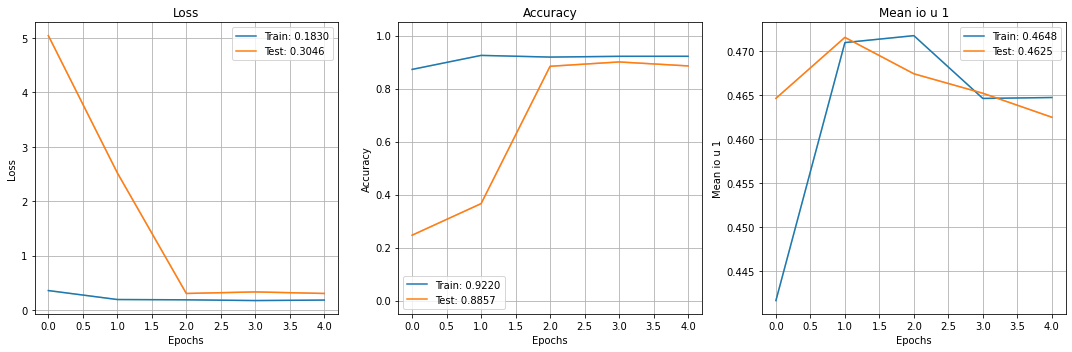

----------------------- I AM DONE -----------------------


In [ ]:
create_model(Backbone='mobilenet' ,pretrained=True,ShowSummery=False,TrainModel=True,TestModel=False)

Found 4810 images belonging to 2 classes.
Found 4810 images belonging to 2 classes.
Found 1202 images belonging to 2 classes.
Found 1202 images belonging to 2 classes.
-------------------Generating UNet Model----------------------
29089792/29084464 [==============================] - 2s 0us/step

| Header               | Value       |
|----------------------+-------------|
| Model                | UNet        |
| BackBone             | densenet121 |
| Number of Layers     | 468         |
| Total params         | 12144977    |
| Trainable params     | 10484113    |
| Non-trainable params | 1660864     |

-------------------Training Model----------------------


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
50/50 [==============================] - 856s 17s/step - loss: 0.2929 - accuracy: 0.8970 - mean_io_u_2: 0.4414 - val_loss: 2.3010 - val_accuracy: 0.8798 - val_mean_io_u_2: 0.4407

Epoch 00001: loss improved from inf to 0.29288, saving model to /content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/UNet_Model_Weights/densenet121/model-0.29.h5
Epoch 2/5
50/50 [==============================] - 820s 16s/step - loss: 0.1939 - accuracy: 0.9173 - mean_io_u_2: 0.4409 - val_loss: 0.9050 - val_accuracy: 0.7147 - val_mean_io_u_2: 0.4423

Epoch 00002: loss improved from 0.29288 to 0.19391, saving model to /content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/UNet_Model_Weights/densenet121/model-0.19.h5
Epoch 3/5
50/50 [==============================] - 828s 17s/step - loss: 0.1928 - accuracy: 0.9150 - mean_io_u_2: 0.4440 - val_loss: 0.7493 - val_accuracy: 0.8597 - val_mean_io_u_2: 0.4439

Epoch 00003: loss improved from 0.19391 to 0.1

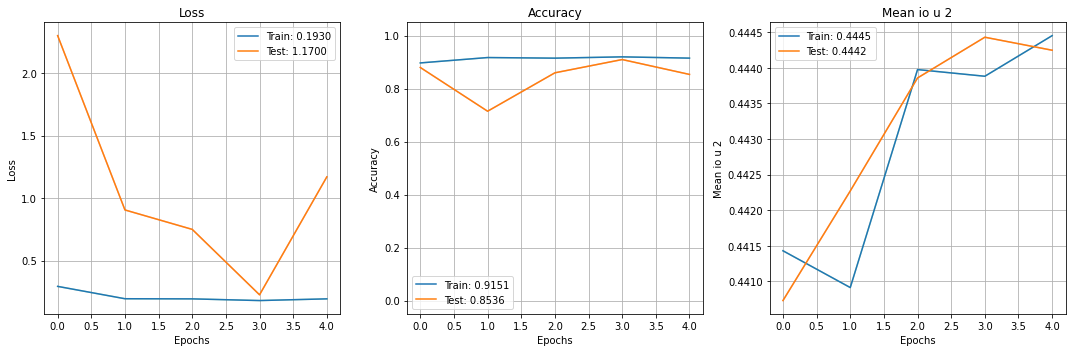

----------------------- I AM DONE -----------------------


In [ ]:
create_model(Backbone='densenet121' ,pretrained=True,ShowSummery=False,TrainModel=True,TestModel=False)

Found 4810 images belonging to 2 classes.
Found 4810 images belonging to 2 classes.
Found 1202 images belonging to 2 classes.
Found 1202 images belonging to 2 classes.
-------------------Generating UNet Model----------------------
94593024/94592056 [==============================] - 4s 0us/step

| Header               | Value    |
|----------------------+----------|
| Model                | UNet     |
| BackBone             | resnet50 |
| Number of Layers     | 231      |
| Total params         | 32561114 |
| Trainable params     | 31350097 |
| Non-trainable params | 1211017  |

-------------------Training Model----------------------


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
50/50 [==============================] - 1101s 22s/step - loss: 0.2500 - accuracy: 0.9117 - mean_io_u_3: 0.4414 - val_loss: 6.7925 - val_accuracy: 0.8845 - val_mean_io_u_3: 0.4409

Epoch 00001: loss improved from inf to 0.25000, saving model to /content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/UNet_Model_Weights/resnet50/model-0.25.h5
Epoch 2/5
50/50 [==============================] - 1031s 21s/step - loss: 0.1912 - accuracy: 0.9176 - mean_io_u_3: 0.4411 - val_loss: 1.3383 - val_accuracy: 0.8869 - val_mean_io_u_3: 0.4410

Epoch 00002: loss improved from 0.25000 to 0.19125, saving model to /content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/UNet_Model_Weights/resnet50/model-0.19.h5
Epoch 3/5
50/50 [==============================] - 1157s 23s/step - loss: 0.1906 - accuracy: 0.9147 - mean_io_u_3: 0.4415 - val_loss: 1.7133 - val_accuracy: 0.7182 - val_mean_io_u_3: 0.4451

Epoch 00003: loss improved from 0.19125 to 0.1905

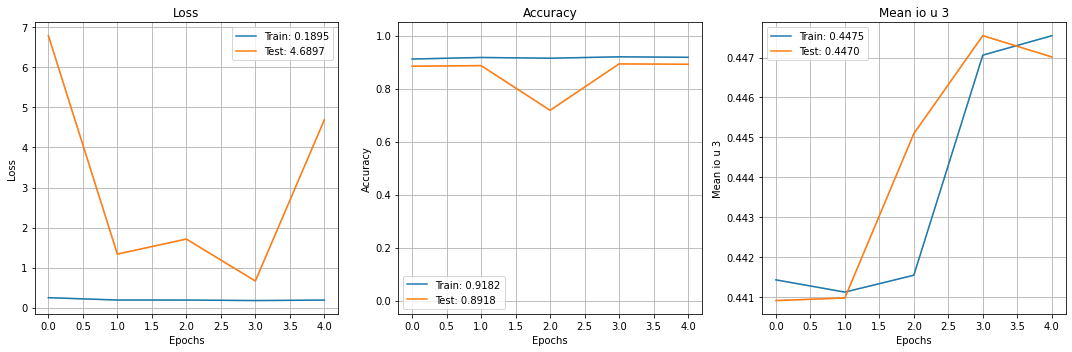

----------------------- I AM DONE -----------------------


In [ ]:
create_model(Backbone='resnet50' ,pretrained=True,ShowSummery=False,TrainModel=True,TestModel=False)

Found 4810 images belonging to 2 classes.
Found 4810 images belonging to 2 classes.
Found 1202 images belonging to 2 classes.
Found 1202 images belonging to 2 classes.
-------------------Generating UNet Model----------------------
87916544/87910968 [==============================] - 4s 0us/step

| Header               | Value       |
|----------------------+-------------|
| Model                | UNet        |
| BackBone             | inceptionv3 |
| Number of Layers     | 352         |
| Total params         | 29933105    |
| Trainable params     | 27098577    |
| Non-trainable params | 2834528     |

-------------------Training Model----------------------


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
50/50 [==============================] - 1075s 22s/step - loss: 0.4733 - accuracy: 0.8198 - mean_io_u_4: 0.4418 - val_loss: 3.2816 - val_accuracy: 0.6545 - val_mean_io_u_4: 0.4449

Epoch 00001: loss improved from inf to 0.47331, saving model to /content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/UNet_Model_Weights/inceptionv3/model-0.47.h5
Epoch 2/5
50/50 [==============================] - 1048s 21s/step - loss: 0.2261 - accuracy: 0.9178 - mean_io_u_4: 0.4458 - val_loss: 0.9799 - val_accuracy: 0.7355 - val_mean_io_u_4: 0.4447

Epoch 00002: loss improved from 0.47331 to 0.22612, saving model to /content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/UNet_Model_Weights/inceptionv3/model-0.23.h5
Epoch 3/5
50/50 [==============================] - 1045s 21s/step - loss: 0.2047 - accuracy: 0.9129 - mean_io_u_4: 0.4448 - val_loss: 2253.9082 - val_accuracy: 0.1111 - val_mean_io_u_4: 0.4374

Epoch 00003: loss improved from 0.22612 

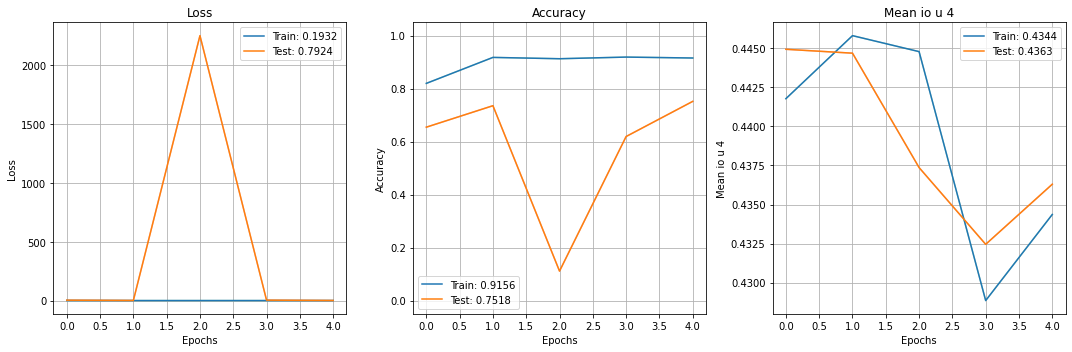

----------------------- I AM DONE -----------------------


In [ ]:
create_model(Backbone='inceptionv3' ,pretrained=True,ShowSummery=False,TrainModel=True,TestModel=False)

Found 4810 images belonging to 2 classes.
Found 4810 images belonging to 2 classes.
Found 1202 images belonging to 2 classes.
Found 1202 images belonging to 2 classes.
-------------------Generating UNet Model----------------------
80142336/80134624 [==============================] - 3s 0us/step

| Header               | Value    |
|----------------------+----------|
| Model                | UNet     |
| BackBone             | vgg19    |
| Number of Layers     | 69       |
| Total params         | 29061969 |
| Trainable params     | 6674257  |
| Non-trainable params | 22387712 |

-------------------Training Model----------------------


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
50/50 [==============================] - 1246s 25s/step - loss: 0.4032 - accuracy: 0.8241 - mean_io_u_5: 0.4414 - val_loss: 0.2844 - val_accuracy: 0.8865 - val_mean_io_u_5: 0.4408

Epoch 00001: loss improved from inf to 0.40319, saving model to /content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/UNet_Model_Weights/vgg19/model-0.40.h5
Epoch 2/5
50/50 [==============================] - 1156s 23s/step - loss: 0.2683 - accuracy: 0.8841 - mean_io_u_5: 0.4409 - val_loss: 0.3153 - val_accuracy: 0.8920 - val_mean_io_u_5: 0.4408

Epoch 00002: loss improved from 0.40319 to 0.26827, saving model to /content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/UNet_Model_Weights/vgg19/model-0.27.h5
Epoch 3/5
50/50 [==============================] - 1106s 22s/step - loss: 0.2395 - accuracy: 0.8971 - mean_io_u_5: 0.4414 - val_loss: 0.2135 - val_accuracy: 0.8933 - val_mean_io_u_5: 0.4418

Epoch 00003: loss improved from 0.26827 to 0.23949, sav

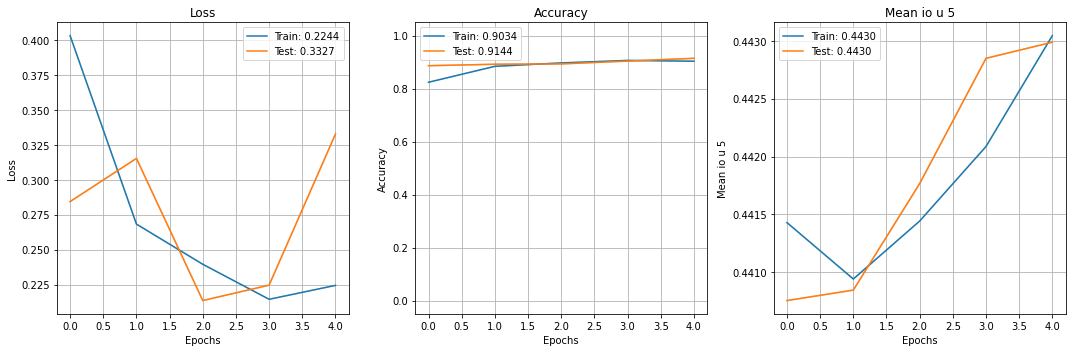

----------------------- I AM DONE -----------------------


In [ ]:
create_model(Backbone='vgg19' ,pretrained=True,ShowSummery=False,TrainModel=True,TestModel=False)

In [ ]:
One_Box  = '0100515c-5204-4f31-98e0-f35e4b00004a.png'	# One Box
Two_Box = '00436515-870c-4b36-a041-de91049b9ab4.png'	# Two Box
Three_Box = '03a9498c-549d-4e7d-800b-e74797f7f625.png'	# Three Box
Four_Box = '0d5bc737-03de-4bb8-98a1-45b7180c3e0f.png'	# Four Box
Not_Normal = '0004cfab-14fd-4e49-80ba-63a80b6bddd6.png'	# No Lung Opacity/Not Normal
Normal = '003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png'	# Normal

test_patient_id = One_Box
image = tf.keras.preprocessing.image.load_img(PneumoniaImg+'/'+test_patient_id, grayscale=False,color_mode="rgb", target_size=(224,224))
input_img = keras.preprocessing.image.img_to_array(image)
input_img = np.array([input_img])  # Convert single image to a batch
input_img = tf.keras.applications.mobilenet.preprocess_input(input_img)
mask = tf.keras.preprocessing.image.load_img(PneumoniaMask+'/'+test_patient_id, color_mode="grayscale", target_size=(224,224))
input_img.shape

Backbone = 'mobilenet'
WEIGHTS_FILE = "/content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/UNet_Model_Weights/mobilenet/model-0.24.h5"
THRESHOLD = 0.8
EPSILON = 0.02

model = Unet(Backbone, input_shape=(224, 224, 3))
model.load_weights(WEIGHTS_FILE)
threshold = 0.0

region = model.predict(input_img)
# region = np.where(region<threshold,0,1)
print(region.shape)
print('Max pixal value :',np.amax(region),'\nMin pixal Value :',np.amin(region))

(1, 224, 224, 1)
Max pixal value : 0.99570465 
Min pixal Value : 1.7399254e-12


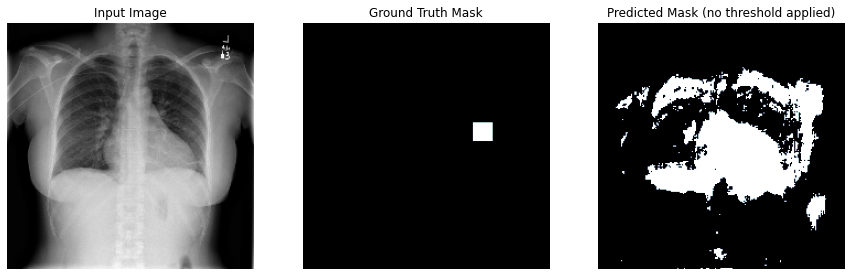

In [ ]:
PredictMask = region[0][:,:,0]
PredictMask = 1.0*(PredictMask>0.5)
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 8))
ax1.imshow(image, cmap = plt.cm.bone)
ax1.set_title('Input Image')
ax1.axis('off')
ax2.imshow(mask, cmap = plt.cm.bone)
ax2.set_title('Ground Truth Mask')
ax2.axis('off')
ax3.imshow(PredictMask, cmap = plt.cm.bone)
ax3.set_title('Predicted Mask (no threshold applied)')
ax3.axis('off')
plt.show()